# Exogenous data management

Exogenous data can be loaded in **EOReader** along the product, as for the DEM.

There are several things you need to know to handle EXO properly.

In [21]:
# Imports
import os

from eoreader.reader import Reader
from eoreader.bands import DEM
from eoreader.keywords import DEM_KW, EXO_KW

In [22]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

In [23]:
# Open the product
path = os.path.join("/media/gsalgues/ESPACE/rasters/SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0")
prod = Reader().open(path)

In [24]:
# EXO data paths
exo_folder = os.path.join("/media/gsalgues/ESPACE/EXO")
s2w = os.path.join(exo_folder, "s2w-globalmask-31TCJ.tif")
dtm = os.path.join("/media/gsalgues/ESPACE/DEM", "output.vrt")

Then you may load specific layer from the EXO folder using the `load` or `stack` function.

To do this, you need to provide the `EXO_KW`.
The expected value is a dictionnary containing the target name of the layer as key, and the `path` as sub-attribute.

In the case where the file provide as path is multi-layer, you must specify the `bandnumber` to load. Band indexes start at 1, if the band index does not exist it return an array of nan, default: `1`.

You can also change the resampling method to apply, `resampler`. Supported options are `bilinear` and `nearest`, default: `bilinear`. 

In [ ]:
loaded_bands = prod.load(
    ['GREEN'],
    **{
        EXO_KW: {'s2w_mask': {'bandnumber' : 1, 'path' : s2w, 'resampler' : 'nearest'}},     
    }
)
# display the xarray.Dataset
loaded_bands

2025-11-19 15:37:22,694 - [DEBUG] - Loading bands ['GREEN']
2025-11-19 15:37:22,697 - [DEBUG] - Read GREEN
2025-11-19 15:37:22,772 - [DEBUG] - Manage nodata for band GREEN
2025-11-19 15:37:22,786 - [DEBUG] - Converting GREEN to reflectance
2025-11-19 15:37:24,778 - [INFO] - Loading bands {'s2w_mask': {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}}
2025-11-19 15:37:24,779 - [DEBUG] - EXO data info: s2w_mask ; {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}
2025-11-19 15:37:24,779 - [DEBUG] - Warping EXO for 20241227T104904_S2THEIA_T31TCJ_L2A
2025-11-19 15:37:24,780 - [DEBUG] - Using EXO: /media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif
2025-11-19 15:37:24,821 - [DEBUG] - Collocating EXO bands
2025-11-19 15:37:24,822 - [DEBUG] - Append EXO bands at the end of current band_dict


/tmp/tmpj71kqouu/tmp_20241227T104904_S2THEIA_T31TCJ_L2A/20241227T104904_S2THEIA_T31TCJ_L2A_EXO_s2w-globalmask-31TCJ.vrt


<xarray.Dataset> Size: 1MB
Dimensions:                  (x: 366, y: 366, band: 1)
Coordinates:
  * x                        (x) float64 3kB 3.002e+05 3.004e+05 ... 4.096e+05
  * y                        (y) float64 3kB 4.9e+06 4.9e+06 ... 4.79e+06
    spatial_ref              int64 8B 0
  * band                     (band) int64 8B 1
Data variables:
    SpectralBandNames.GREEN  (band, y, x) float32 536kB 0.0 0.0 ... 0.0606
    s2w_mask                 (band, y, x) float32 536kB dask.array<chunksize=(1, 366, 366), meta=np.ndarray>
Attributes:
    long_name:         GREEN s2w_mask
    constellation:     Sentinel-2 Theia
    constellation_id:  S2_THEIA
    product_path:      /media/gsalgues/ESPACE/rasters/SENTINEL2B_20241227-104...
    product_name:      SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0
    product_filename:  SENTINEL2B_20241227-104904-377_L2A_T31TCJ_C_V4-0
    instrument:        MSI
    product_type:      MSIL2A
    acquisition_date:  20241227T104904
    condensed_name:    20241227T104904_S2THEIA_T31TCJ_L2A
    orbit_direction:   DESCENDING
    cloud_cover:       21.0

You can then access the loaded layer as you would do for any band of the product.

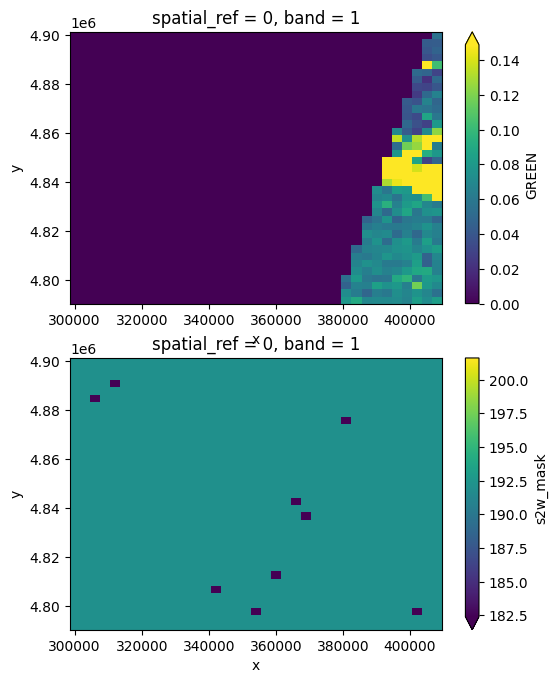

In [26]:
import matplotlib.pyplot as plt
# Plot EXO bands
ncols = len(loaded_bands)
plt.figure(figsize=(6, 6 * ncols))
i = 0
for key in loaded_bands.keys():
    axes = plt.subplot(3, 1, i+1)
    loaded_bands[key][0, ::10, ::10].plot.imshow(robust=True)
    i += 1

The same arguments can be used to create a stack:

In [ ]:

stacked_bands = prod.stack(
  ['GREEN'],
  pixel_size=60.,
  stack_path=os.path.join(prod.output, "stack.tif"),
    **{
        EXO_KW: {'s2w_mask': {'bandnumber' : 1, 'path' : s2w, 'resampler' : 'nearest'}},     
    }
)

2025-11-19 15:37:25,737 - [DEBUG] - Loading bands ['GREEN']
2025-11-19 15:37:25,740 - [DEBUG] - Read GREEN
2025-11-19 15:37:25,761 - [DEBUG] - Manage nodata for band GREEN
2025-11-19 15:37:25,771 - [DEBUG] - Converting GREEN to reflectance
2025-11-19 15:37:44,704 - [INFO] - Loading bands {'s2w_mask': {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}}
2025-11-19 15:37:44,705 - [DEBUG] - EXO data info: s2w_mask ; {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}
2025-11-19 15:37:44,706 - [DEBUG] - Already existing EXO for 20241227T104904_S2THEIA_T31TCJ_L2A. Skipping process.
2025-11-19 15:37:44,781 - [DEBUG] - Collocating EXO bands
2025-11-19 15:37:44,781 - [DEBUG] - Append EXO bands at the end of current band_dict


{'exo': {'s2w_mask': {'bandnumber': 1, 'path': '/media/gsalgues/ESPACE/EXO/s2w-globalmask-31TCJ.tif', 'resampler': 'nearest'}}}


2025-11-19 15:38:02,508 - [DEBUG] - Stacking


[ 96. 192.]


2025-11-19 15:38:23,610 - [DEBUG] - Saving stack


[ 96. 192.]


2


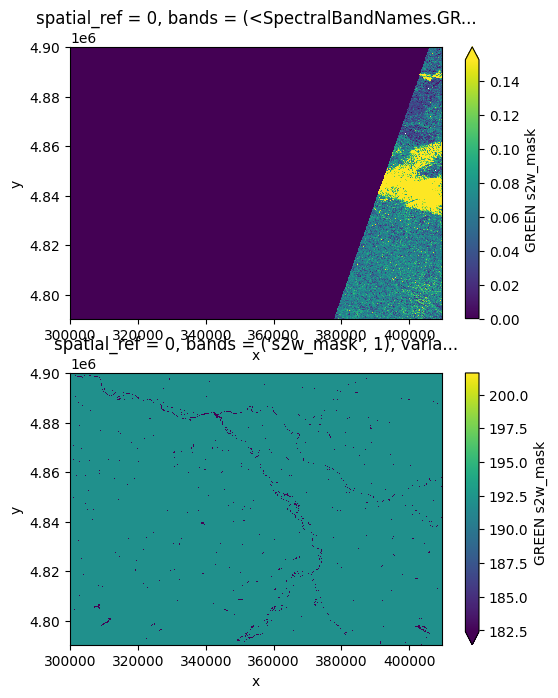

In [28]:
# Plot EXO bands
ncols = len(stacked_bands)
print(ncols)
plt.figure(figsize=(6, 6 * ncols))
for i in range(0,len(stacked_bands)):
    axes = plt.subplot(3, 1, i+1)
    stacked_bands[i, ::10, ::10].plot.imshow(robust=True)
    i += 1